# 练习题 Exercise

## ex.1

Q:为什么要使用`Data API` ？

> **Ingesting a large dataset and preprocessing it** efficiently can be a complex engineering challenge. **The Data API makes it fairly simple.** It offers many features, including loading data from various sources (such as text or binary files), reading data in parallel from multiple sources, transforming it, interleaving the records, shuffling the data, batching it, and prefetching it.

## ex.2

Q:将大数据分成多个文件有什么好处？

> - Splitting a large dataset into multiple files makes it possible to **shuffle it at a coarse level before shuffling it at a finer level using a shuffling buffer.** 
- It also makes it possible to **handle huge datasets** that do not fit on a single machine. It’s also simpler to manipulate thousands of small files rather than one huge file; for example, it’s easier to split the data into multiple subsets. 
- Lastly, if **the data is split across multiple files spread across multiple servers**, it is possible to download several files from different servers simultaneously, which **improves the bandwidth usage.**

## ex.3

Q:训练中，如何断定输入流水线是瓶颈？如何处理瓶颈？

> You can **use TensorBoard to visualize profiling data**: if the GPU is not fully utilized then your input pipeline is likely to be the bottleneck. You can fix it by making sure it **reads and preprocesses the data in multiple threads in parallel, and ensuring it prefetches a few batches.** If this is insufficient to get your GPU to 100% usage during training, make sure your **preprocessing code is optimized.** You can also try **saving the dataset into multiple TFRecord files**, and if necessary **perform some of the preprocessing ahead of time** so that it does not need to be done on the fly during training (TF Transform can help with this). If necessary, **use a machine with more CPU and RAM**, and ensure that the GPU bandwidth is large enough.

## ex.4 

Q:可以将任何二进制数据存入TFRecord文件吗，还是只能保存序列化的协议缓冲区？

> Waiting for replenishment

## ex.5

Q:为什么要将所有数据转换为`Example protobuf格式`？为什么不使用自己的`protobuf`定义？

> Waiting for replenishment

## ex.6 

Q:使用`TFRecord`时，什么时候要压缩？为什么不系统化的做？

> Waiting for replenishment

## ex.7

Q:对数据预处理,可以在编写数据文件时，或在`tf.data`流水线内，或在模型内的预处理层中，或使用`TF Transform`。这几种方法各有什么优缺点？

>Let’s look at the pros and cons of each preprocessing option:
- If you preprocess the data **when creating the data files**.
    - the training script will  **run faster** , since it will not have to perform preprocessing on the fly. In some cases, the preprocessed data will also be much smaller than the orig inal data, so you **can save some space and speed up downloads**. It may also be **helpful to materialize the preprocessed data**, for example to  inspect it or archive it. 
    - However, this approach has a few cons. First, **it’s not easy to experiment with various preprocessing logics** if you need to generate a preprocessed dataset for each variant. Second, if you want to perform data augmentation, you have to materialize many variants of your dataset, which **will use a large amount of disk space and take a lot of time to generate.** Lastly, the trained model will expect preprocessed data, so you will **have to add preprocessing code in your application before it calls the model.**
- If the data is preprocessed with the **`tf.data` pipeline**
    - **it’s much easier to tweak the preprocessing logic and apply data augmentation.** Also, tf.data makes it easy to **build highly efficient preprocessing pipelines** (e.g., with multithreading and prefetching). 
    - However, preprocessing the data this way will **slow down training.** Moreover, each training instance will be preprocessed once per epoch rather than just once if the data was preprocessed when creating the data files. Lastly, **the trained model will still expect preprocessed data.**
- If you **add preprocessing layers to your model**
    - you will **only have to write the preprocessing code once** for both training and inference. If your model needs to be deployed to many different platforms, you will not need to write the preprocessing code multiple times. Plus, you **will not run the risk of using the wrong preprocessing logic for your model**, since it will be part of the model. 
    - On the downside, preprocessing the data will **slow down training**, and each training instance will be preprocessed once per epoch. Moreover, by default the preprocessing operations will run on the GPU for the current batch (you will not benefit from parallel preprocessing on the CPU, and prefetching). Fortunately, the upcoming Keras preprocessing layers should be able to lift the preprocessing operations from the preprocessing layers and run them as part of the tf.data pipeline, so you will benefit from multithreaded execution on the CPU and prefetching.
- Lastly, using TF Transform for preprocessing 
    - gives you many of the benefits from the previous options: the preprocessed data is materialized, each instance is preprocessed just once (**speeding up training**), and **preprocessing layers get generated automatically** so you only need to write the preprocessing code once. 
    - The main drawback is the fact that **you need to learn how to use this tool.**

## ex.8

Q:列举一些可用于编码分类特征的常用技术。文本呢？

>Let’s look at how to encode categorical features and text: 
- To encode a categorical feature that has a natural order, such as a movie rating (e.g., “bad,” “average,” “good”), the simplest option is to use ordinal encoding: sort the categories in their natural order and map each category to its rank (e.g., “bad” maps to 0, “average” maps to 1, and “good” maps to 2). However, most categorical features don’t have such a natural order. For example, there’s no natural order for professions or countries. In this case, you can use one-hot encoding or, if there are many categories, embeddings.
- For text, one option is to use a bag-of-words representation: a sentence is represented by a vector counting the counts of each possible word. Since common words are usually not very important, you’ll want to use TF-IDF to reduce their weight. Instead of counting words, it is also common to count n-grams, which are sequences of n consecutive words—nice and simple. Alternatively, you can encode each word using word embeddings, possibly pretrained. Rather than encoding words, it is also possible to encode each letter, or subword tokens (e.g., splitting “smartest” into “smart” and “est”). These last two options are discussed in Chapter 16.

## ex.9

Q:完成以下任务
>1. 加载 `Fashion MNIST`数据集；将其分为训练集、验证集和测试集.打乱训练集次序：
2. 将毎个数据集保存到多个 `TFRecord`文件中。 每个记录都 应该是具有两个特征的序列化 `Example protobuf`：序列化的图像(使用`tf.io.serialize_tensor()`序列化每个图像)和标签。
3. 使用`tf.data`为每个集合 创建一个有效的数据集。
4. 使用 `Keras`模型训练这些数据集，包括预处理层来标准化每个输入特征。尝试使输入流水线尽可能高效，使用 `Tensorboard`来可视化数据分析.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import os
import matplotlib.pyplot as plt

def initialization():
    keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)

1. Load the `Fashion MNIST` dataset;split it into a training set, a validation set, and a test set.

In [2]:
fashion_MNIST = keras.datasets.fashion_mnist.load_data()
(X_train_full,y_train_full), (X_test,y_test) = fashion_MNIST

X_val, y_val = X_train_full[:5000], y_train_full[:5000]
X_train, y_train = X_train_full[5000:], y_train_full[5000:]

train_set = (X_train,y_train)
val_set = (X_val, y_val)
test_set = (X_test, y_test)

2. Shuffle the training set

In [3]:
initialization()

train_set = tf.data.Dataset.from_tensor_slices(train_set).shuffle(len(X_train))
val_set = tf.data.Dataset.from_tensor_slices(val_set)
test_set = tf.data.Dataset.from_tensor_slices(test_set)

2022-10-26 10:30:23.421267: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 10:30:23.443495: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 10:30:23.443625: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 10:30:23.444138: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

3. Save each dataset to multiple TFRecord files.Each record should be a serialized `Example` protobuf with two features: the serialized image (use `tf.io.serialize_tensor()` to serialize each image), and the label.

In [4]:
BytesList = tf.train.BytesList
FloatList = tf.train.FloatList
Int64List = tf.train.Int64List
Feature = tf.train.Feature
Features = tf.train.Features
Example = tf.train.Example

In [5]:
def create_example(image, label):
    image_data = tf.io.serialize_tensor(image)
    #image_data = tf.io.encode_jpeg(image[..., np.newaxis])
    return Example(
        features=Features(
            feature={
                "image": Feature(bytes_list=BytesList(value=[image_data.numpy()])),
                "label": Feature(int64_list=Int64List(value=[label])),
            }))

In [6]:
for image, label in val_set.take(1):
    print(create_example(image, label))

features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\010\004\022\010\022\002\010\034\022\002\010\034\"\220\006\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\001\000\000\rI\000\000\001\004\000\000\000\000\001\001\000\000\000\000\000\000\000\000\000\000\000\000\000\003\000$\210\177>6\000\000\000\001\003\004\000\000\003\000\000\000\000\000\000\000\000\000\000\000\000\006\000f\314\260\206\220{\027\000\000\000\000\014\n\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\233\354\317\262k\234\241m@\027M\202H\017\000\000\000\000\000\000\000\000\000\000\000\001\000E\317\337\332\330\330\243\177yz\222\215X\254B\000\000\00

The following function saves a given dataset to a set of TFRecord files. 

The examples are written to the files in a round-robin fashion. To do this, we enumerate all the examples using the `dataset.enumerate()` method, and we compute `index % n_shards` to decide which file to write to. We use the standard `contextlib.ExitStack` class to make sure that all writers are properly closed whether or not an I/O error occurs while writing.

In [7]:
from contextlib import ExitStack

def write_tfrecords(name, dataset, n_shards=10):
    paths = ["{}.tfrecord-{:05d}-of-{:05d}".format(name, index, n_shards)
             for index in range(n_shards)]
    with ExitStack() as stack:
        writers = [stack.enter_context(tf.io.TFRecordWriter(path))
                   for path in paths]
        for index, (image, label) in dataset.enumerate():
            shard = index % n_shards
            example = create_example(image, label)
            writers[shard].write(example.SerializeToString())
    return paths

In [8]:
train_filepaths = write_tfrecords("../TFRecords/my_fashion_mnist.train", train_set)
val_filepaths = write_tfrecords("../TFRecords/my_fashion_mnist.valid", val_set)
test_filepaths = write_tfrecords("../TFRecords/my_fashion_mnist.test", test_set)

4. Use `tf.data` to create an efficient dataset for each set.

In [9]:
def preprocess(tfrecord):
    feature_descriptions = {
        "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "label": tf.io.FixedLenFeature([], tf.int64, default_value=-1)
    }
    example = tf.io.parse_single_example(tfrecord, feature_descriptions)
    image = tf.io.parse_tensor(example["image"], out_type=tf.uint8)
    #image = tf.io.decode_jpeg(example["image"])
    image = tf.reshape(image, shape=[28, 28])
    return image, example["label"]

def mnist_dataset(filepaths, n_read_threads=5, shuffle_buffer_size=None,
                  n_parse_threads=5, batch_size=32, cache=True):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [10]:
train_set = mnist_dataset(train_filepaths, shuffle_buffer_size=60000)
val_set = mnist_dataset(val_filepaths)
test_set = mnist_dataset(test_filepaths)

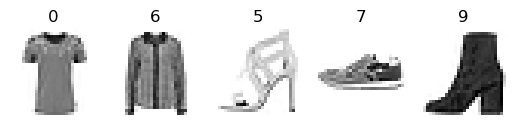

In [11]:
for X, y in train_set.take(1):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X[i].numpy(), cmap="binary")
        plt.axis("off")
        plt.title(str(y[i].numpy()))

5. Use a Keras model to train these datasets, including a preprocessing layer to standardize each input feature. 

In [12]:
initialization()

In [13]:
class Standardization(keras.layers.Layer):
    def adapt(self, data_sample):
        self.means_ = np.mean(data_sample, axis=0, keepdims=True)
        self.stds_ = np.std(data_sample, axis=0, keepdims=True)
    def call(self, inputs):
        return (inputs-self.means_) / (self.stds_+keras.backend.epsilon())
    
standardization = Standardization(input_shape=[28,28])    

In [14]:
sample_image_batches = train_set.take(100).map(
                        lambda img, label : img)
# sample_images = np.concatenate(
#                     list(sample_image_batches.as_numpy_iterator()),
#                     axis=0).astype(np.float32)
# standardization.adapt(sample_images)

# model = keras.models.Sequential([
#     standardization,
#     keras.layers.Flatten(),
#     keras.layers.Dense(100, activation="relu"),
#     keras.layers.Dense(10, activation="softmax")
# ])
# model.compile(loss="sparse_categorical_crossentropy",
#               optimizer="nadam", metrics=["accuracy"])

In [15]:
# from datetime import datetime
# logs = os.path.join(os.curdir, "my_logs",
#                     "run_" + datetime.now().strftime("%Y%m%d_%H%M%S"))

# tensorboard_cb = tf.keras.callbacks.TensorBoard(
#     log_dir=logs, histogram_freq=1, profile_batch=10)

# model.fit(train_set, epochs=5, validation_data=val_set,
#           callbacks=[tensorboard_cb])

In [16]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

Reusing TensorBoard on port 6006 (pid 48780), started 0:24:25 ago. (Use '!kill 48780' to kill it.)

## ex.10

Q:在本练习中,你将下载一个数据集,对其进行拆分,创建一个`tf.data.Dataset` 来加载并对其进行有效的预处理,然后构建和训练一个包含`Embedding`层的二进制分类模型.
>1. 下载大型电影评论数据集,其中包含来自 Internet电影数据库的50 000条电影评论。数据有train和test两个目录,毎个目录包含一个带有12 500个肯定评论的pos子目录和一个带有12 500个否定评论的neg子目录。毎个评论均存储在单独的文本文件中。还有其他文件和文件夹(包括顶处理的词袋),但是在本练习中我们将忽略它.
2. 将测试集分为一个验证集(15 000)和一个测试集(1 0000)
3. 使用 `tf.data`为每个集合创建一个有效的数据集。
4. 创建一个二进制分类模型,使用 `Textvectorization` 层对每个评论进行预处理。如果` Textvectorization`层尚不可用(或者你想挑战),请尝试创建自定义预处理层：你可以使用`tf.strings`包中的函数，例如，`1ower()`来使所有内容变为小写， `regex_replace()`将标点符号替换为空格， `split()`在空格上拆分单词。你应该使用査找表输出单词素引，该索引必在 `adapt()`方法中准备.
5. 添加一个 `Embedding`层并计算每个评论的平均嵌入值，乘以单词数的平方根。然后将这种重新缩放的均值嵌入传递给模型的其余部分。 
6. 训练模型，看看可以得到什么准确率。尝试优化你的流水线以使训练速度更快.
7. 使用`TFDS`可以更轻松地加載相同的数据集：`tfds.1oad("imdb_reviews")`

### a.

> 1. Download the Large Movie Review Dataset

In [17]:
from pathlib import Path

DOWNLOAD_ROOT = "http://ai.stanford.edu/~amaas/data/sentiment/"
FILENAME = "aclImdb_v1.tar.gz"
filepath = keras.utils.get_file(fname=FILENAME, origin=DOWNLOAD_ROOT+FILENAME, extract=True)
path = Path(filepath).parent / "aclImdb"   # 数据集根目录地址 
path

84125825/84125825 [==============================] - 17s 0us/step


PosixPath('/home/sora/.keras/datasets/aclImdb')

In [18]:
# 查看该数据集的树形目录
for name, subdirs, files in os.walk(path):
    indent = len(Path(name).parts) - len(path.parts)   # 2 -> 'train', 'pos'
    print("    " * indent + Path(name).parts[-1] + os.sep)  # os.sep -> '/'
    for index, filename in enumerate(sorted(files)):
        if index == 3:
            print("    " * (indent + 1) + "...")
            break
        print("    " * (indent + 1) + filename)

aclImdb/
    README
    imdb.vocab
    imdbEr.txt
    test/
        labeledBow.feat
        urls_neg.txt
        urls_pos.txt
        neg/
            0_2.txt
            10000_4.txt
            10001_1.txt
            ...
        pos/
            0_10.txt
            10000_7.txt
            10001_9.txt
            ...
    train/
        labeledBow.feat
        unsupBow.feat
        urls_neg.txt
        ...
        unsup/
            0_0.txt
            10000_0.txt
            10001_0.txt
            ...
        neg/
            0_3.txt
            10000_4.txt
            10001_4.txt
            ...
        pos/
            0_9.txt
            10000_8.txt
            10001_10.txt
            ...


In [19]:
def review_paths(dirpath):
    return [str(path) for path in dirpath.glob("*.txt")]   # 遍历目录

train_pos = review_paths(path / "train" / "pos")
train_neg = review_paths(path / "train" / "neg")
test_val_pos = review_paths(path / "test" / "pos")
test_val_neg = review_paths(path / "test" / "neg")

len(train_pos), len(train_neg), len(test_val_pos), len(test_val_neg)

(12500, 12500, 12500, 12500)

### b.

> 2. Split the test set into a validation set (15,000) and a test set (10,000).

In [20]:
np.random.shuffle(test_val_pos)
np.random.shuffle(test_val_pos)

In [21]:
# 验证集:15 000 ( pos 和 neg 各7 500)
val_pos = test_val_pos[5000:]
val_neg = test_val_neg[5000:]

# 测试集:10 000 ( pos 和 neg 各5 000)
test_pos = test_val_pos[:5000]
test_neg = test_val_neg[:5000]

In [22]:
len(val_pos), len(test_pos)

(7500, 5000)

### c.

> 3. Use `tf.data` to create an efficient dataset for each set.



-  If the dataset fits in memory

In [23]:
def imdb_dataset(filepaths_pos, filepaths_neg):
    reviews = []
    labels = []  
    
    # pos评论label标记为1 neg评价label为0
    postive = (filepaths_pos, 1)
    negative = (filepaths_neg, 0)
    
    for filepaths, label in (negative, postive):
        for filepath in filepaths:
            with open(filepath) as review_file:
                reviews.append(review_file.read())   # 提取评论数据
            labels.append(label)                     # 提取标签
    
    return tf.data.Dataset.from_tensor_slices(
                (tf.constant(reviews), tf.constant(labels))
            )

In [24]:
# for review, label in imdb_dataset(train_pos, train_neg):
#    print(review)
#    print(label)

In [25]:
%timeit -r1 for review, label in imdb_dataset(train_pos, train_neg).repeat(20): pass

32.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


遍历20次大概需要花费38秒.

-  If the dataset does not fit in memory

由于每条评论只占一行(使用`<br />`换行),因此我们可以使用`TextLineDataset`读取评论.否则,我们将不得不使用预处理输入文件(转化为`TFRcords`)

对于非常大的数据集,使用`Apache Beam`等工具.

In [26]:
def imdb_dataset(filepaths_pos, filepaths_neg, n_read_threads=tf.data.AUTOTUNE):
    dataset_neg = tf.data.TextLineDataset(filenames=filepaths_neg,
                                          num_parallel_reads=n_read_threads)
    dataset_neg = dataset_neg.map(lambda review:(review, 0))
    
    dataset_pos = tf.data.TextLineDataset(filenames=filepaths_pos,
                                          num_parallel_reads=n_read_threads)
    dataset_pos = dataset_pos.map(lambda review:(review, 1))
    
#     return tf.data.Dataset.from_tensor_slices(
#                 (dataset_pos, dataset_neg)
#             )    
    return tf.data.Dataset.concatenate(dataset_pos, dataset_neg)

In [27]:
%timeit -r1 for review, label in imdb_dataset(train_pos, train_neg).repeat(20): pass

35.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


现在，遍历数据集 20 次大约需要 43 秒。这要前面的慢得多，主要是因为数据集没有缓存在 RAM 中，因此必须在每个时期重新加载。

在 `.repeat(10)` 之前添加 `.cache()`，耗时将和前面的一样快.

In [28]:
%timeit -r1 for review, label in imdb_dataset(train_pos, train_neg).cache().repeat(20): pass

30.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


- apply on the data set

In [29]:
batch_size = 32

train_set = imdb_dataset(train_pos, train_neg).shuffle(25000).batch(batch_size).prefetch(1)
val_set = imdb_dataset(val_pos, val_neg).batch(batch_size).prefetch(1)
test_set = imdb_dataset(test_pos, test_neg).batch(batch_size).prefetch(1)

### d.

> 4. Create a binary classification model, using a `TextVectorization` layer to preprocess each review. If the `TextVectorization` layer is not yet available (or if you like a challenge), try to create your own custom preprocessing layer: you can use the functions in the `tf.strings` package, for example `lower()` to make everything lowercase, `regex_replace()` to replace punctuation with spaces, and `split()` to split words on spaces. You should use a lookup table to output word indices, which must be prepared in the `adapt()` method._

- 我们先写一个函数对评论进行预处理，将它们裁剪为300个字符，将它们转换为小写，然后将`<br />`和所有非字母字符替换为空格，将评论拆分为单词，最后填充或裁剪每个评论所以它最终得到了恰好达到`n_words `长度.

In [30]:
X_example = tf.constant(["It's a great, great movie! I loved it.",
                         "It was terrible, run away!!!"])

In [31]:
tf.shape(X_example) * tf.constant([1, 0]) + tf.constant([0,50])  # shape=[2,50]

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([ 2, 50], dtype=int32)>

In [32]:
def preprocess(X_batch, n_words=50):
    shape = tf.shape(X_batch) * tf.constant([1, 0]) + tf.constant([0,n_words])
    Z = tf.strings.substr(X_batch, pos=0, len=300)  # 子字符串的操作
    Z = tf.strings.lower(Z)  # 转换为小写
    Z = tf.strings.regex_replace(Z, b"<br\\s*/?>", b" ") # 正则表达式进行字符串替换
    Z = tf.strings.regex_replace(Z, b"[^a-z]", b" ")
    Z = tf.strings.split(Z)  # 拆分为单词
    return Z.to_tensor(shape=shape, default_value=b"<pad>") # 不足的位置由<pad>填充

In [33]:
preprocess(X_example, n_words=6)

<tf.Tensor: shape=(2, 6), dtype=string, numpy=
array([[b'it', b's', b'a', b'great', b'great', b'movie'],
       [b'it', b'was', b'terrible', b'run', b'away', b'<pad>']],
      dtype=object)>

- 现在让我们编写第二个函数，该函数将采用与`preprocess()`函数的输出格式相同的数据样本，并将输出最高 `max_size` 最常用词的列表，确保填充标记是第一个

In [34]:
from collections import Counter

def get_vocabulary(data_sample, max_size=1000):
    preprocessed_reviews = preprocess(data_sample).numpy()
    counter = Counter()  # 初始化计数器
    
    for words in preprocessed_reviews:
        for word in words:
            if word !=  b'<pad>':
                counter[word] += 1  
    #print({word:count for word, count in counter.most_common()})
    return [b"<pad>"] + [word for word, count in counter.most_common(max_size)]

In [35]:
get_vocabulary(X_example)

[b'<pad>',
 b'it',
 b'great',
 b's',
 b'a',
 b'movie',
 b'i',
 b'loved',
 b'was',
 b'terrible',
 b'run',
 b'away']

- 现在我们准备好创建`TextVectorization`层。它的构造函数只保存超参数（`max_vocabulary_size`和 `n_oov_buckets`）。 `adapt()` 使用 `get_vocabulary()` 函数计算词汇数量，然后它构建一个`StaticVocabularyTable`（更多细节参见第 16 章）。 `call()` 预处理评论以获得每个评论的填充单词列表，然后它使用`StaticVocabularyTable`查找词汇表中每个单词的索引：

In [36]:
class TextVectorization(keras.layers.Layer):
    def __init__(self, max_vocabulary_size=1000, n_oov_buckets=100, dtype=tf.string, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        self.max_vocabulary_size = max_vocabulary_size
        self.n_oov_buckets = n_oov_buckets

    def adapt(self, data_sample):
        self.vocab = get_vocabulary(data_sample, max_size=self.max_vocabulary_size)
        words = tf.constant(self.vocab)
        
        word_ids = tf.range(len(self.vocab), dtype=tf.int64)  # X_example -> 12
        vocab_init = tf.lookup.KeyValueTensorInitializer(keys=words, values=word_ids) # 为查找表创建一个初始化程序 
        self.table = tf.lookup.StaticVocabularyTable(
                        initializer=vocab_init, 
                        num_oov_buckets=self.n_oov_buckets) # 创建查找表
        
    def call(self, inputs):
        preprocessed_inputs = preprocess(inputs)
        return self.table.lookup(preprocessed_inputs)

In [37]:
text_vectorization = TextVectorization()

text_vectorization.adapt(data_sample=X_example)
text_vectorization(X_example)

<tf.Tensor: shape=(2, 50), dtype=int64, numpy=
array([[ 1,  3,  4,  2,  2,  5,  6,  7,  1,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0],
       [ 1,  8,  9, 10, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0]])>

每条评论都经过清理和标记，然后每个单词都被编码为词汇表中的索引（所有 0 对应于 `<pad>` ）。


现在让我们创建另一个`TextVectorization`层，让我们将其调整到完整的 IMDB 训练集（如果训练集不适合 RAM，我们可以通过调用 `train_set.take(500)` 使用较小的训练集样本）

In [38]:
max_vocabulary_size = 1000
n_oov_buckets = 100

sample_review_batches = train_set.map(lambda review, label: review)
sample_reviews = np.concatenate(list(sample_review_batches.as_numpy_iterator()),
                                axis=0)

text_vectorization = TextVectorization(max_vocabulary_size, n_oov_buckets,
                                       input_shape=[])
text_vectorization.adapt(sample_reviews)

In [39]:
text_vectorization(X_example)

<tf.Tensor: shape=(2, 50), dtype=int64, numpy=
array([[  9,  14,   2,  64,  64,  12,   5, 256,   9,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  9,  13, 269, 531, 334,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])>

由此可见，在`X_example`上词汇的`IDs`更大，因为词汇表中的词汇量更大.

In [40]:
text_vectorization.vocab[:10]  # 在评论中最常见的词

[b'<pad>', b'the', b'a', b'of', b'and', b'i', b'to', b'is', b'this', b'it']

现在要构建我们的模型，我们需要以某种方式对所有这些单词` IDs `进行编码。

一种方法是创建词袋：对于每个评论，以及词汇表中的每个词，我们计算该词在评论中出现的次数。

In [41]:
simple_example = tf.constant([[1, 3, 1, 0, 0], [2, 2, 0, 0, 0]])
tf.one_hot(simple_example, 4)

<tf.Tensor: shape=(2, 5, 4), dtype=float32, numpy=
array([[[0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]],

       [[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]]], dtype=float32)>

In [42]:
tf.reduce_sum(tf.one_hot(simple_example, 4), axis=1)

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[2., 2., 0., 1.],
       [3., 0., 2., 0.]], dtype=float32)>

第一个review有2次0，2次1，0次2，1次3，所以它的bag-of-words表示是[2, 2, 0, 1]。同理，第二个review有3次0，0次1，以此类推...

让我们将这个逻辑包装在一个小的自定义层中，让我们对其进行测试。我们将删除单词 0 的计数，因为它对应于我们不关心的 `<pad>` 标记。

In [43]:
class BagOfWords(keras.layers.Layer):
    def __init__(self, n_tokens, dtype=tf.int32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        self.n_tokens = n_tokens
    def call(self, inputs):
        one_hot = tf.one_hot(inputs, self.n_tokens)
        return tf.reduce_sum(one_hot, axis=1)[:, 1:]

In [44]:
bag_of_words = BagOfWords(n_tokens=4)
bag_of_words(simple_example)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[2., 0., 1.],
       [0., 2., 0.]], dtype=float32)>

现在让我们为我们的训练集创建另一个具有合适词汇量的`BagOfWord`

In [45]:
max_vocabulary_size = 1000
n_oov_buckets = 100

n_tokens = max_vocabulary_size + n_oov_buckets + 1   # add 1 for <pad>
bag_of_words = BagOfWords(n_tokens)

接下来准备训练模型

In [46]:
initialization()
model = keras.models.Sequential([
    text_vectorization,  # 自定义TextVectorization预处理层
    bag_of_words,        # 词袋编码层
    keras.layers.Dense(100, activation=keras.activations.relu),
    keras.layers.Dense(1, activation=keras.activations.sigmoid),
])
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer='nadam',
              metrics=[keras.metrics.binary_accuracy])
model.fit(train_set, epochs=5, validation_data=val_set)

Epoch 1/5
782/782 [==============================] - 4s 4ms/step - loss: 0.5437 - binary_accuracy: 0.7162 - val_loss: 0.5167 - val_binary_accuracy: 0.7342
Epoch 2/5
782/782 [==============================] - 4s 4ms/step - loss: 0.4672 - binary_accuracy: 0.7738 - val_loss: 0.5061 - val_binary_accuracy: 0.7422
Epoch 3/5
782/782 [==============================] - 4s 4ms/step - loss: 0.4149 - binary_accuracy: 0.8078 - val_loss: 0.5189 - val_binary_accuracy: 0.7381
Epoch 4/5
782/782 [==============================] - 4s 4ms/step - loss: 0.3428 - binary_accuracy: 0.8548 - val_loss: 0.5428 - val_binary_accuracy: 0.7306
Epoch 5/5
782/782 [==============================] - 4s 3ms/step - loss: 0.2606 - binary_accuracy: 0.9056 - val_loss: 0.5920 - val_binary_accuracy: 0.7262


在第一个 epoch 之后，我们在验证集上获得了大约 74.7% 的准确率，但之后模型没有取得显着进展。我们会在第 16 章做得更好。现在的重点只是使用 `tf.data` 和 `Keras` 预处理层执行有效的预处理。

### e.

>  5. Add an `Embedding` layer and compute the mean embedding for each review, multiplied by the square root of the number of words (see Chapter 16). This rescaled mean embedding can then be passed to the rest of your model.

对此,我们需要一个函数:计算每条评论的平均嵌入值，乘以单词数的平方根。

对于每个句子。此函数需要计算 $M \times \sqrt N$
- $M$ 是句子中所有词嵌入的平均值（不包括填充标记)
- $N$ 是句子中的单词数（也不包括填充标记）.

我们可以将  $M$ 重写为$\dfrac{S}{N}$，
- $S $是所有词嵌入的总和（我们是否在这个总和中包含填充标记并不重要，因为它们的表示是零向量）。 

函数重写为$M \times \sqrt N = \dfrac{S}{N} \times \sqrt N = \dfrac{S}{\sqrt N \times \sqrt N} \times \sqrt N= \dfrac{S}{\sqrt N}$.

In [47]:
def compute_mean_embedding(inputs):
    not_pad = tf.math.count_nonzero(inputs, axis=-1)  # 用于统计数组中非零元素(不包括填充标记)的个数
    n_words = tf.math.count_nonzero(not_pad, axis=-1, keepdims=True)    
    sqrt_n_words = tf.math.sqrt(tf.cast(n_words, tf.float32))
    return tf.reduce_sum(inputs, axis=1) / sqrt_n_words

In [48]:
another_example = tf.constant([[[1., 2., 3.], [4., 5., 0.], [0., 0., 0.]],
                               [[6., 0., 0.], [0., 0., 0.], [0., 0., 0.]]])
compute_mean_embedding(another_example)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[3.535534 , 4.9497476, 2.1213205],
       [6.       , 0.       , 0.       ]], dtype=float32)>

In [49]:
not_pad = tf.math.count_nonzero(another_example, axis=-1)
not_pad

<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
array([[3, 2, 0],
       [1, 0, 0]])>

In [50]:
n_words = tf.math.count_nonzero(not_pad, axis=-1, keepdims=True)   
n_words

<tf.Tensor: shape=(2, 1), dtype=int64, numpy=
array([[2],
       [1]])>

让我们检查一下这是否正确。第一个评论包含 2 个词（最后一个标记是零向量，代表 `<pad> `标记）。让我们计算这两个词的平均嵌入，并将结果乘以 2 的平方根：

In [51]:
tf.reduce_mean(another_example[0:1, :2], axis=1) * tf.sqrt(2.)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[3.535534 , 4.9497476, 2.1213202]], dtype=float32)>

现在让我们检查第二条评论，它只包含一个词（我们忽略了两个填充标记）：

In [52]:
tf.reduce_mean(another_example[1:2, :1], axis=1) * tf.sqrt(1.)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[6., 0., 0.]], dtype=float32)>

现在我们准备好训练我们的最终模型。它和以前一样，除了我们用一个`Embedding`层替换了`BagOfWords`层，然后是一个`compute_mean_embedding`层的 `Lambda `层：

In [53]:
embedding_size = 20

model = keras.models.Sequential([
    text_vectorization,
    keras.layers.Embedding(input_dim=n_tokens,
                           output_dim=embedding_size,
                           mask_zero=True), # <pad> tokens => zero vectors
    keras.layers.Lambda(compute_mean_embedding),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid"),
])

### f.

> 6. Train the model and see what accuracy you get. Try to optimize your pipelines to make training as fast as possible.

In [54]:
model.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])
model.fit(train_set, epochs=5, validation_data=val_set)

Epoch 1/5
782/782 [==============================] - 4s 3ms/step - loss: 0.5553 - accuracy: 0.7093 - val_loss: 0.5164 - val_accuracy: 0.7398
Epoch 2/5
782/782 [==============================] - 4s 3ms/step - loss: 0.4960 - accuracy: 0.7546 - val_loss: 0.5114 - val_accuracy: 0.7405
Epoch 3/5
782/782 [==============================] - 4s 3ms/step - loss: 0.4872 - accuracy: 0.7601 - val_loss: 0.5098 - val_accuracy: 0.7397
Epoch 4/5
782/782 [==============================] - 4s 3ms/step - loss: 0.4798 - accuracy: 0.7637 - val_loss: 0.5102 - val_accuracy: 0.7425
Epoch 5/5
782/782 [==============================] - 4s 3ms/step - loss: 0.4726 - accuracy: 0.7656 - val_loss: 0.5102 - val_accuracy: 0.7396


该模型并没有使用嵌入更好（但我们会在第 16 章中做得更好）。流水线看起来足够快（我们之前对其进行了优化）。

### g.

> 7. Use TFDS to load the same dataset more easily: `tfds.load("imdb_reviews")`.

In [56]:
import tensorflow_datasets as tfds

datasets = tfds.load(name="imdb_reviews")
train_set, test_set = datasets["train"], datasets["test"]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteGA5EGZ/imdb_reviews-train.tfrecord*...…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteGA5EGZ/imdb_reviews-test.tfrecord*...:…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteGA5EGZ/imdb_reviews-unsupervised.tfrec…

Dataset imdb_reviews downloaded and prepared to ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [57]:
for example in train_set.take(1):
    print(example["text"])
    print(example["label"])

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


2022-10-26 10:37:09.370611: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


> create:Apotosome 12/13/21

> update:Apotosome 10/26/22